# Invariance
This tutorial shows how to generate the plots about the representation of invariance w.r.t. plane height, or generalization capacity of an individual neuron, as in the paper in Fig. 6E and Fig. S4

This script should be run using the libraries from the environment.yml file.

In [48]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from rowwise_neuron_curves_controls import *
import os
from scipy.stats import t
from controls_main import RunInfo
import copy

uniquezs = list(np.array([-45., -42., -39., -36., -33., -30., -27., -24., -21., -18., -15.,
                     -12.,  -9.,  -6.,  -3.,   0.,   3.,   6.,   9.,  12.,  15.,  18.,
                     21.,  24.,  27.,  30.]).astype(int))
uniquexs = list(np.array([ 6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36., 39., 42.,
                     45., 48., 51., 54.]).astype(int))
uniqueheights = [uniquezs, uniquexs]
orientations = ['hor', 'vert']

nzs = len(uniquezs)
nxs = len(uniquexs)
zpos0 = uniquezs.index(0)
xpos0 = int(len(uniquexs)/2)
x0 = uniquexs[xpos0]
z0 = 0

def format_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

## A: Change in PD over Planes for Individual Neurons

In [49]:
modelinfo = dict({'type': 'S',
            'base': 'spatial_temporal_4_8-16-16-32_64-64-64-64_5272',
            'name': 'spatial_temporal_4_8-16-16-32_64-64-64-64_5272_1',
            'shortbase': 'Spatial-Temporal',
            'shortname': 'Spatial-Temporal_1',
            'nlayers': 8,
            'max_act': 14,
            'control': False,
            'cmap': 'Blues_r',
            'color': 'C0',
            'control_cmap': 'Purples_r'})

runinfo = RunInfo({'expid': 102, #internal experiment id
                   'datafraction': 0.5,
                   'randomseed': 2000,
                   'randomseed_traintest': 42,
                   'dirr2threshold': 0.2,
                   'verbose': 0,
                   'model_experiment_id': 4, #as per Pranav's model generation
                   'basefolder' : '/home/kai/Dropbox/DeepDrawData/analysis-data/', #point to analysis-data folder
                       #in DeepDrawData folder from Dropbox, include trailing slash
                   'orientation' : 'hor',
                   'height' : 'all'
            })

specify options

In [73]:
orientation = 'hor' #one of ['hor', 'vert']
ilayer = 0 #one of 0-8 for Spatial-Temporal or 0-4 for Spatiotemporal
r2threshold = 0.2 #threshold above which units are counted as directionally tuned

In [50]:
def normalized_angle_calculator(angle, angle_pos0):
    """Returns the difference between two angles (between -pi and pi)
    
    Arguments
    ---------
    angle : float, angle to be normalized
    angle_pos0 : float, angle that we are normalizing by
    
    Returns
    -------
    norm : float, normalized angle
    """
    
    
    norm = angle - angle_pos0
    if(norm > np.pi):
        norm = norm - 2*np.pi
    if(norm < - np.pi):
        norm = norm + 2*np.pi
    return(norm)

In [74]:
ior = orientations.index(orientation)
hts = uniqueheights[ior]

In [108]:
nlayers = modelinfo['nlayers'] + 1 #add 1 for spindles

fset = 'vel'
mmod = 'std'

##SAVE PDs & R2s
#runinfo_temp = copy.deepcopy(runinfo)

runinfo_temp = RunInfo()

for key, value in runinfo.items():
    runinfo_temp[key] = value

runinfo_temp['orientation'] = orientation
runinfo_temp['height'] = uniqueheights[ior][0]

testevals = np.load('%s/l%d_%s_mets_%s_%s_test.npy' %(runinfo_temp.resultsfolder(modelinfo, 'vel'), ilayer, fset, mmod, runinfo_temp.planestring()))        
dirtuning = testevals[...,1,3:5].reshape((-1,2))            
prefdirs = np.apply_along_axis(angle_xaxis, 1, dirtuning)

pds_sp = np.zeros((len(uniqueheights[ior]), len(prefdirs)))

for iht, ht in enumerate(uniqueheights[ior]):
    #print(runinfo_temp['height'])
    runinfo_temp['height'] = ht
    #print(runinfo_temp['height'])
    #print(runinfo_temp.planestring(), runinfo_temp['height'])
    testevals = np.load('%s/l%d_%s_mets_%s_%s_test.npy' %(runinfo_temp.resultsfolder(modelinfo, 'vel'), ilayer, fset, mmod, runinfo_temp.planestring()))
    dirtuning = testevals[...,1,3:5].reshape((-1,2))

    #apply r2threshold
    for neuron, score in enumerate(testevals[...,1,1].flatten()):
        if score < r2threshold:
            dirtuning[neuron] = np.nan

    prefdirs = np.apply_along_axis(angle_xaxis, 1, dirtuning)
    pds_sp[iht] = prefdirs

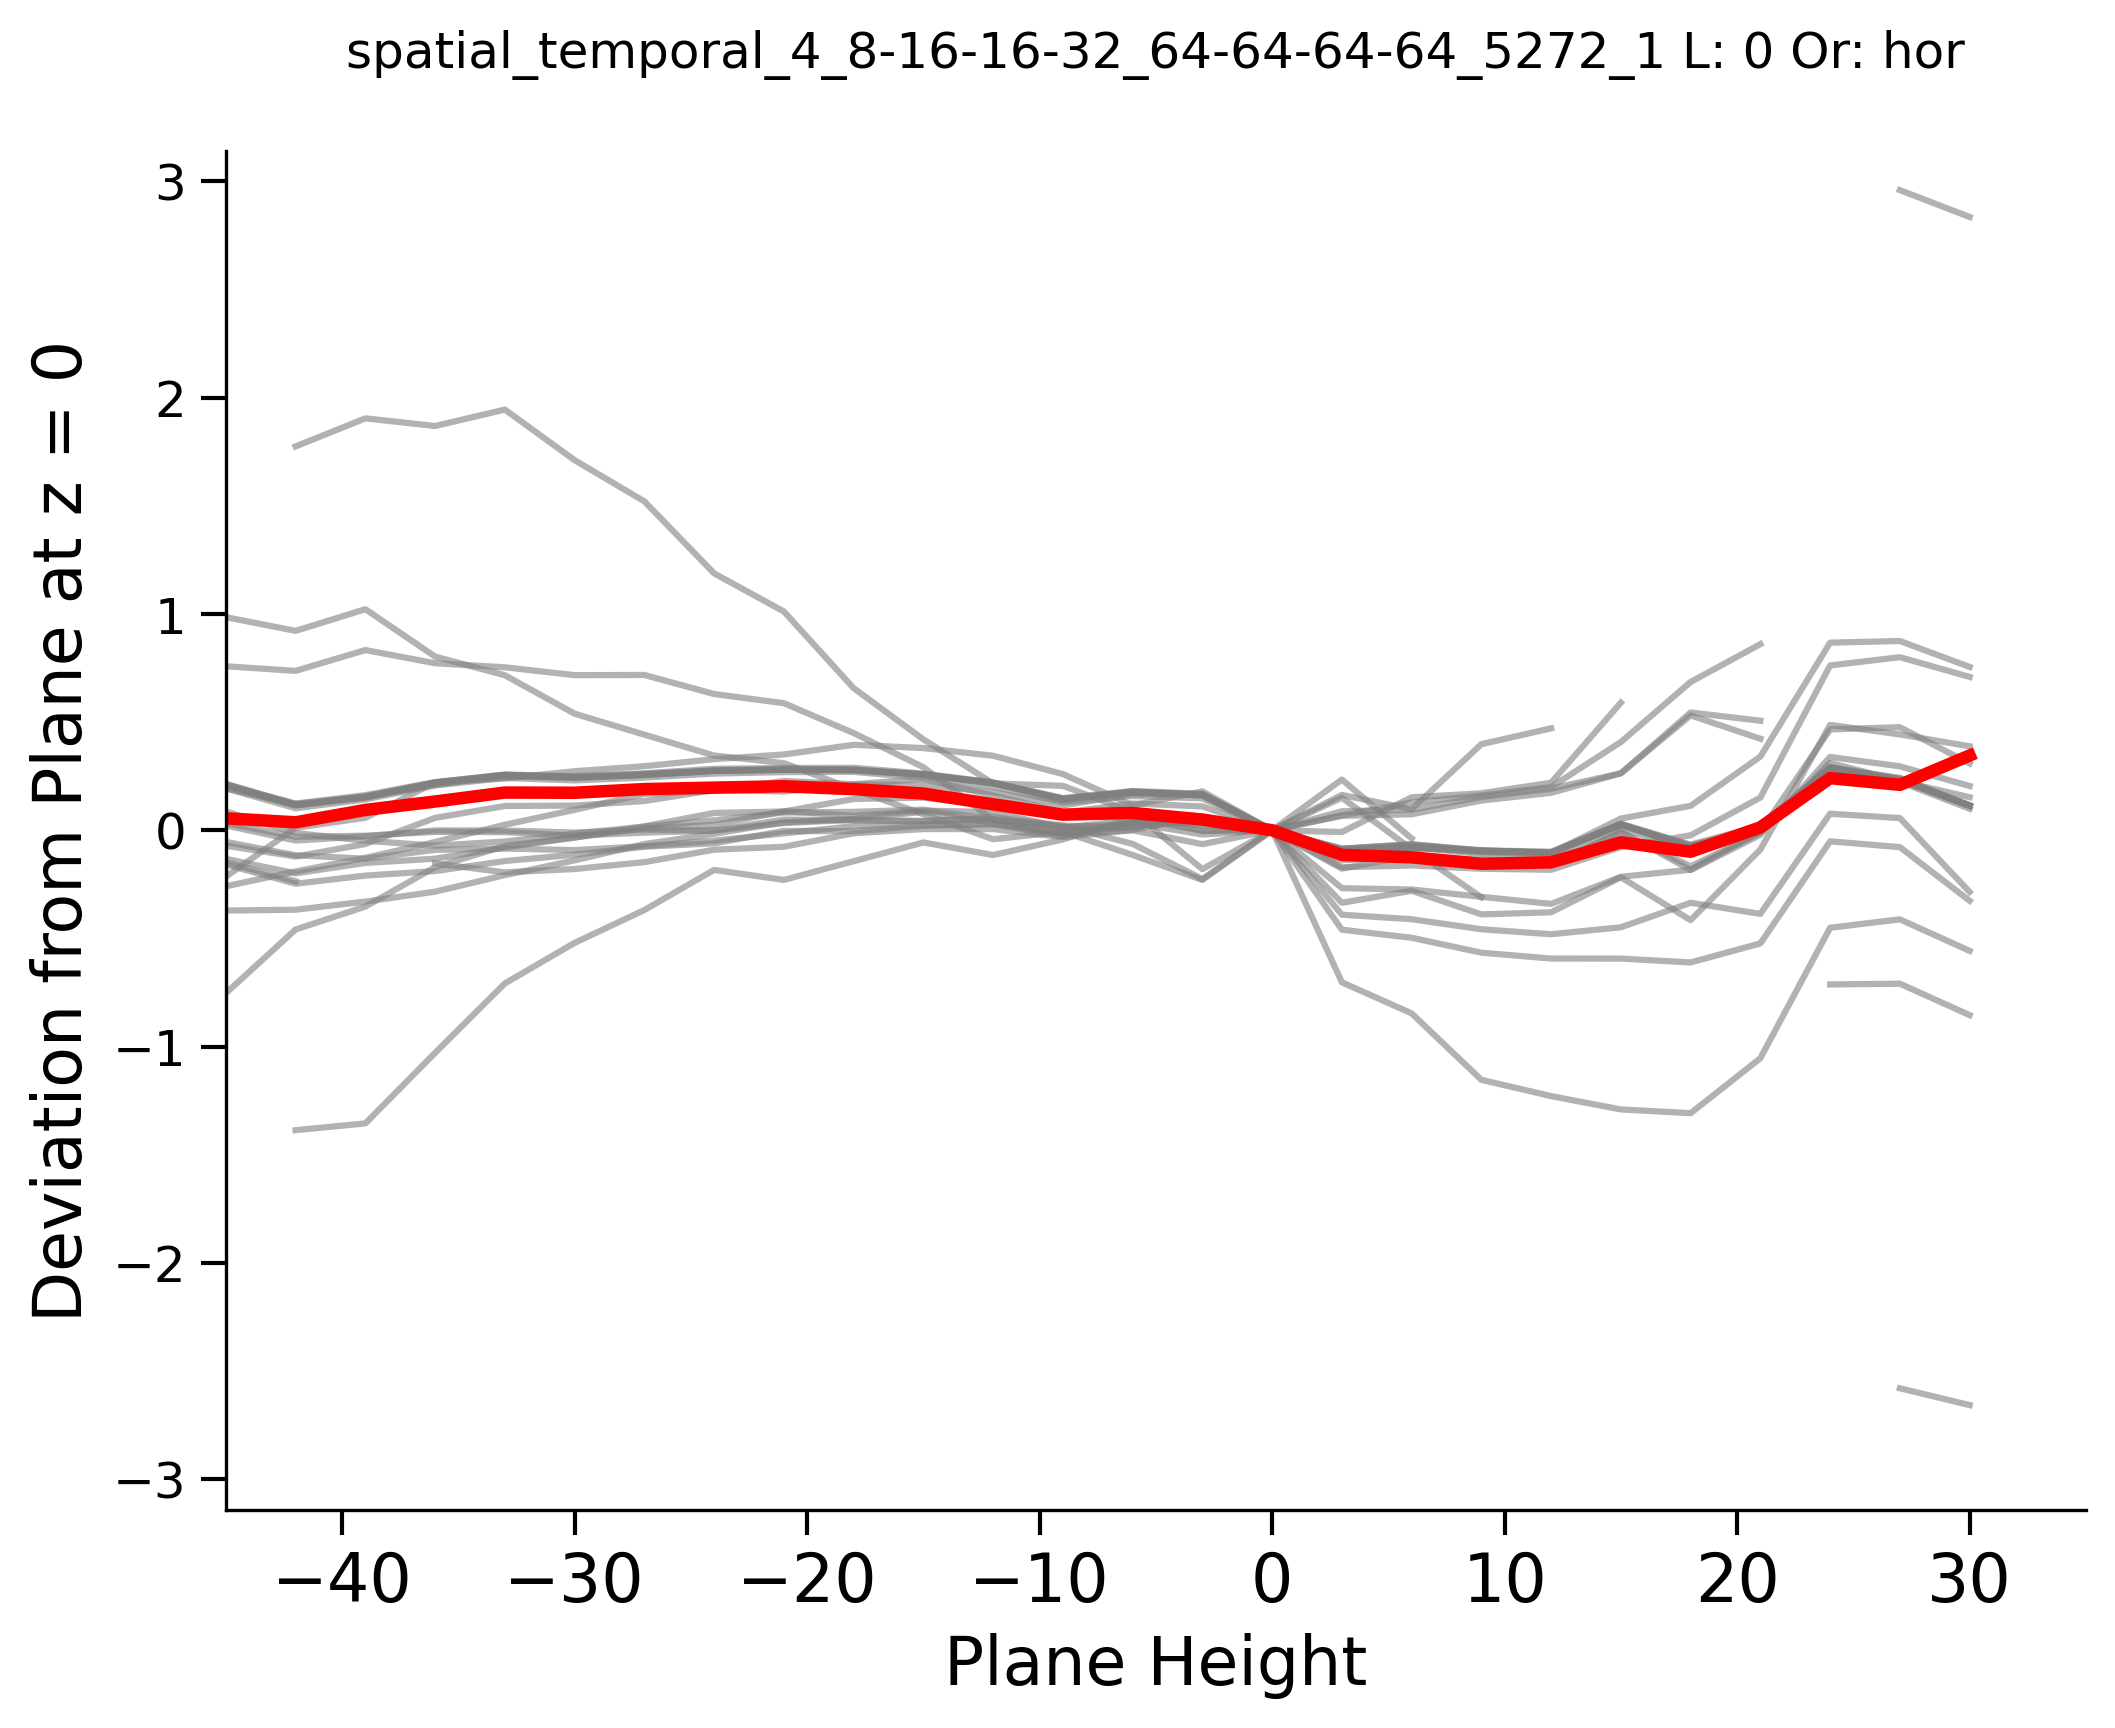

In [115]:
fig = plt.figure(figsize=(8,6),dpi=300)

if orientation == 'hor':
    pos0 = zpos0
    hstr = 'z = %d' %z0
else:
    pos0 = xpos0
    hstr = 'x = %d' %x0

neuronpds = []

for neuron in range(len(pds_sp[0])):
    plt.plot(hts, [normalized_angle_calculator(pds_sp[i][neuron], pds_sp[pos0][neuron]) for i in range(len(hts))], alpha=0.6, color='grey')

    neuronpds.append([normalized_angle_calculator(pds_sp[i][neuron], pds_sp[pos0][neuron]) for i in range(len(hts))])

neuronpds = np.vstack(neuronpds).astype('float64')

plt.plot(hts, np.nanmean(neuronpds,axis=0), linewidth=3, color='red')

plt.ylim((-np.pi, np.pi))

if orientation == 'hor':
    plt.xlim((-45, 35))
else:
    plt.xlim((3, 57))

plt.xlabel('Plane Height')
plt.ylabel('Deviation from Plane at %s' %hstr)

format_axis(plt.gca())
plt.title('%s L: %d Or: %s' %(modelinfo['shortname'], ilayer, orientation))
plt.show()


## B: Mean Absolute Deviation

read in data

In [118]:
modelbase = modelinfo['base']
modelnames = [modelbase + '_%d' %i for i in np.arange(1,6)]

##SAVE PDs & R2s

alltraineddevsim_hor = []
alltraineddevsim_vert = []
allcontroldevsim_hor = []
allcontroldevsim_vert = []

for im, mname in enumerate(modelnames):

    trainedmodel = modelinfo.copy()
    trainedmodel['name'] = mname

    controlmodel = modelinfo.copy()
    controlmodel['name'] = mname + 'r'

    zpos0 = uniquezs.index(0)        
    tmf = runinfo.generalizationfolder(trainedmodel, 'ind_neuron_invar_collapsed_beautified')
    tmdevmean_hor = pd.read_csv(os.path.join(tmf, 'ind_neuron_invar_hor_deviations_02.csv'), index_col = 0).values #mean absolute deviation over neurons saved here
    tmdevmean_vert = pd.read_csv(os.path.join(tmf, 'ind_neuron_invar_vert_deviations_02.csv'), index_col = 0).values

    tmdevmean_hor[:,zpos0] = np.nan
    tmdevmean_vert[:,zpos0] = np.nan

    alltraineddevsim_hor.append(tmdevmean_hor)
    alltraineddevsim_vert.append(tmdevmean_vert)

    cmf = runinfo.generalizationfolder(controlmodel, 'ind_neuron_invar_collapsed_beautified')
    cmdevmean_hor = pd.read_csv(os.path.join(cmf, 'ind_neuron_invar_hor_deviations_02.csv'), index_col = 0).values
    cmdevmean_vert = pd.read_csv(os.path.join(cmf, 'ind_neuron_invar_vert_deviations_02.csv'), index_col = 0).values    

    cmdevmean_hor[:,zpos0] = np.nan
    cmdevmean_vert[:,zpos0] = np.nan

    allcontroldevsim_hor.append(cmdevmean_hor)
    allcontroldevsim_vert.append(cmdevmean_vert)

In [119]:
if orientation == 'hor':
    alltmdevmeans = np.stack(alltraineddevsim_hor)
    allcmdevmeans = np.stack(allcontroldevsim_hor)
else:
    alltmdevmeans = np.stack(alltraineddevsim_vert)
    allcmdevmeans = np.stack(allcontroldevsim_vert)
    
layers = list(range(nlayers))

plot

/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/kai/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/kai/anaconda3/lib/python3.7/site-pa

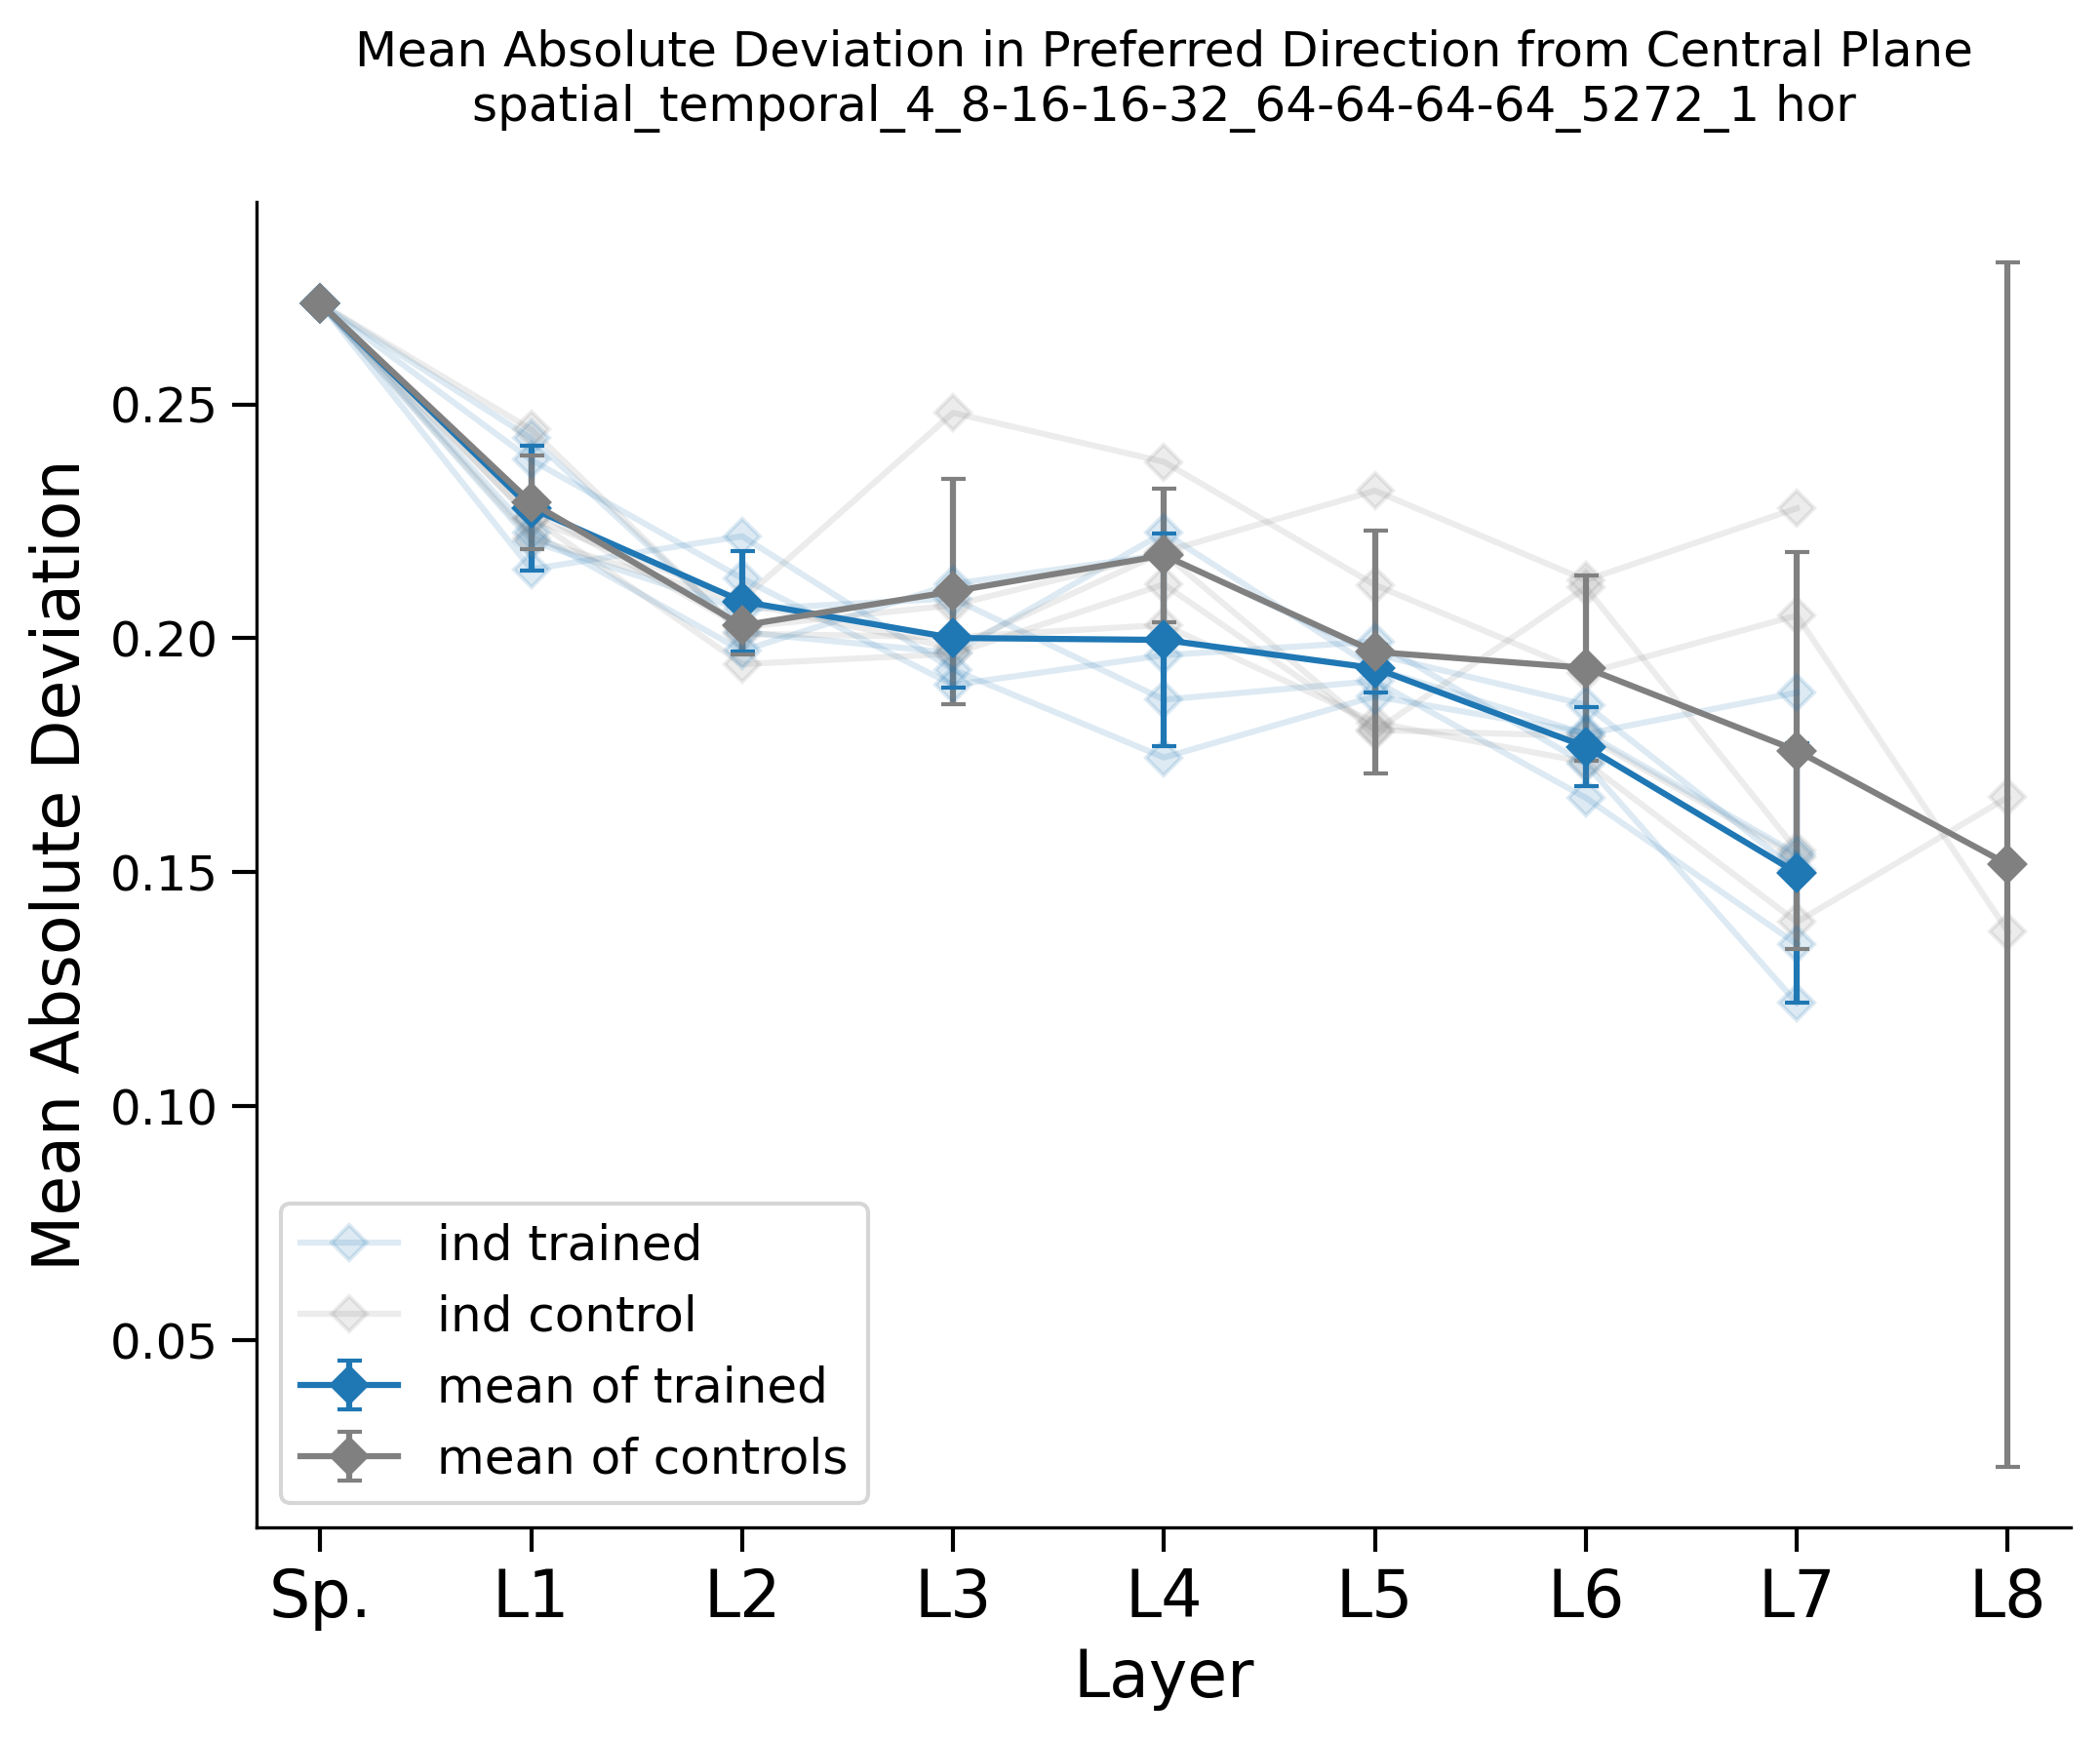

In [126]:
n_tms = np.sum(~np.isnan(np.nanmean(np.abs(alltmdevmeans), axis=2)), axis=0)
n_cms = np.sum(~np.isnan(np.nanmean(np.abs(allcmdevmeans), axis=2)), axis=0)

trained_t_corr = np.array([t.ppf(0.975, n - 1) for n in n_tms])
control_t_corr = np.array([t.ppf(0.975, n - 1) for n in n_cms])

tmsmean = np.nanmean(np.nanmean(np.abs(alltmdevmeans), axis=2), axis=0)
cmsmean = np.nanmean(np.nanmean(np.abs(allcmdevmeans), axis=2), axis=0)
errs_tmsmean = np.nanstd(np.nanmean(np.abs(alltmdevmeans), axis=2), axis=0) / np.sqrt(n_tms) * trained_t_corr
errs_cmsmean = np.nanstd(np.nanmean(np.abs(allcmdevmeans), axis=2), axis=0) / np.sqrt(n_cms) * control_t_corr

#statistical significance
tms = np.nanmean(np.abs(alltmdevmeans), axis=2) #axis 0: models, axis 1: layers
cms = np.nanmean(np.abs(allcmdevmeans), axis=2)

n_comparisons = len(layers) - 1
for layer in layers:
    tml = tms[:, layer]
    cml = cms[:, layer]

    tml_nanmask = ~np.isnan(tml)
    cml_nanmask = ~np.isnan(cml)

    nanmask = tml_nanmask * cml_nanmask

    tml = tml[nanmask]
    cml = cml[nanmask]

figboth = plt.figure(figsize=(8,6), dpi=300)

for i in range(len(alltmdevmeans)):
    plt.plot(layers, np.nanmean(np.abs(alltmdevmeans[i]), axis=1), color=trainedmodel['color'], marker = 'D', alpha = 0.15, label='ind trained')
    plt.plot(layers, np.nanmean(np.abs(allcmdevmeans[i]), axis=1), color='grey', marker = 'D', alpha = 0.15, label='ind control')

plt.errorbar(layers, tmsmean, yerr=errs_tmsmean, marker='D', color=trainedmodel['color'], capsize=3.0, label='mean of trained')
plt.errorbar(layers, cmsmean, yerr=errs_cmsmean, marker = 'D', color='grey', capsize=3.0, label='mean of controls')

plt.xticks(list(range(len(layers))), ['Sp.'] + ['L%d' %(i+1) for i in range(len(layers))])
plt.xlim((-0.3, len(layers)-0.7))
plt.xlabel('Layer')
plt.ylabel('Mean Absolute Deviation')

ax = plt.gca()
format_axis(ax)
handles, _ = ax.get_legend_handles_labels()
handles = np.array(handles)

plt.legend(handles[[0,1,10,11]], ['ind trained', 'ind control', \
            'mean of trained', 'mean of controls'])

plt.title('Mean Absolute Deviation in Preferred Direction from Central Plane\n%s %s' %(modelinfo['shortname'], orientation))

plt.show()